In [1]:
%reload_ext autoreload
%autoreload 2

from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
import nelpy as nel
from ripple_heterogeneity.place_cells import maps, ratemap_correlations_context

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
import os
from statannotations.Annotator import Annotator
from itertools import combinations

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

## locate sessions with multi same maze

In [2]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

epoch_df = pd.DataFrame()
for basepath in df.basepath:
    epochs = loading.load_epoch(basepath)
    epoch_df = pd.concat([epoch_df, epochs], ignore_index=True)
epoch_df = epoch_df.query("environment != 'sleep'")


In [3]:
for basepath in epoch_df.basepath.unique():
    epoch_df.loc[epoch_df.basepath.values == basepath,"n_unique"] = epoch_df[epoch_df.basepath == basepath].environment.nunique()

In [4]:
# use groupby to find basepaths with multiple environments that are the same
epoch_df_multi = (
    epoch_df.groupby("basepath")
    .apply(
        lambda x: pd.Series(
            {
                "multiple_environments": (
                    (x.environment.nunique() != x.shape[0]) & (x.n_unique.iloc[0] > 1)
                ),
                "environments": x.environment.values,
            }
        )
    )
    .reset_index()
)
epoch_df_multi = epoch_df_multi.query("multiple_environments == True").reset_index(drop=True)
epoch_df_multi.head()

,basepath,multiple_environments,environments
0,Z:\Data\AYAold\AYA7\day25,True,"[cheeseboard, box, box, box]"
1,Z:\Data\GirardeauG\Rat08\Rat08-20130710,True,"[linear, linear, linear, water]"
2,Z:\Data\GirardeauG\Rat10\Rat10-20140619,True,"[linear, linear, linear, unknown]"
3,Z:\Data\Kenji\2006-4-10,True,"[linear, linear, open, linear, linear, open]"
4,Z:\Data\Kenji\2006-4-18,True,"[linear, linear, linear, linear, open, tmaze]"


In [ ]:
# basepath = r"Z:\Data\GirardeauG\Rat10\Rat10-20140619"
# ratemap_correlations_context.run(basepath,n_shuff=3,parallel_shuff=False)

In [ ]:
save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\ratemap_correlations_context_v2"
)

batch_analysis.run(
    epoch_df_multi,
    save_path,
    ratemap_correlations_context.run,
    parallel=True,
    verbose=True,
)

In [8]:
save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\ratemap_correlations_context_v2"
)
results_df = batch_analysis.load_results(save_path,add_save_file_name=True)

In [9]:
results_df = results_df.query("not task.str.contains('wheel')")


In [16]:
results_df["pair_pass_spatial_shuff"] = (results_df.ref_spatial_pval < 0.05) & (results_df.target_spatial_pval < 0.05)

In [ ]:
# results_df.query("n_pass_spatial_shuff>0 and not deepSuperficial == 'middle'")

<AxesSubplot: xlabel='save_file_name', ylabel='correlation'>

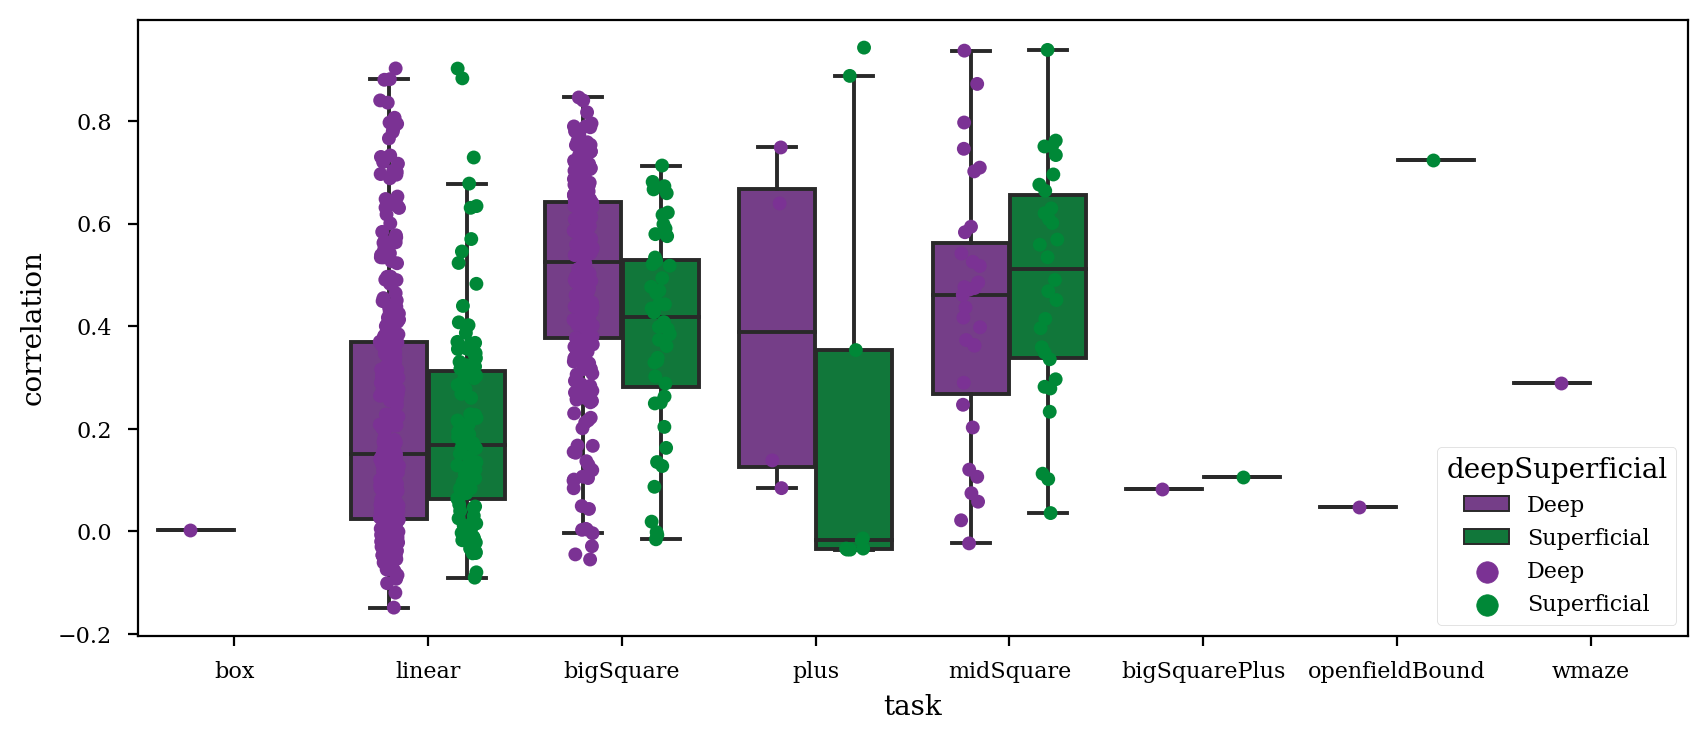

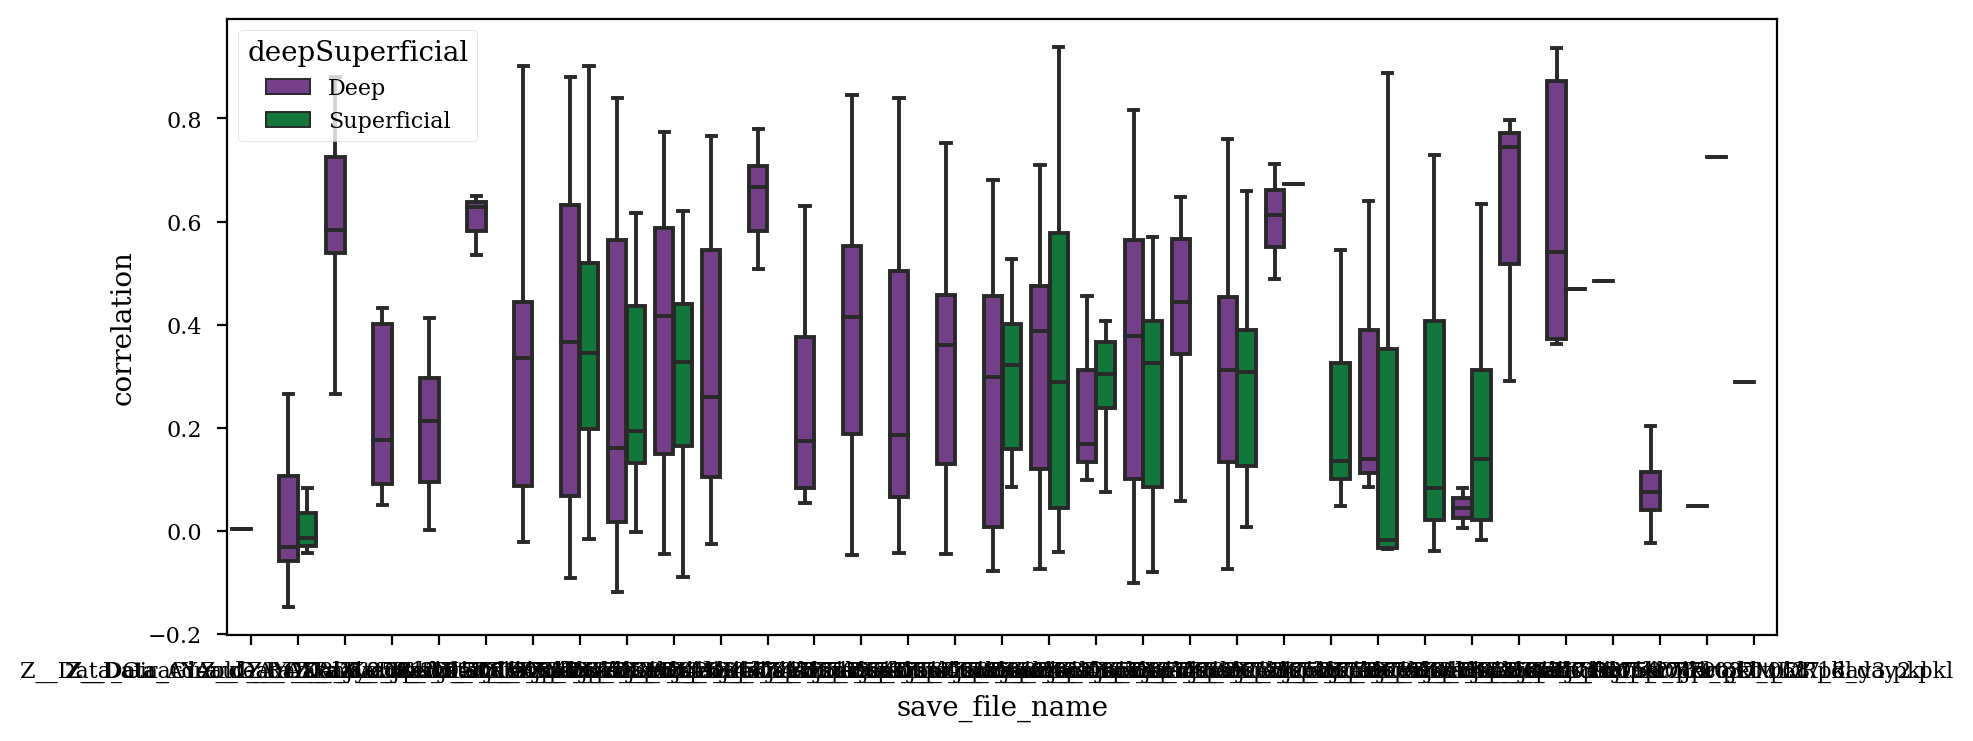

In [21]:
plt.figure(figsize=(10, 4))
sns.boxplot(
    data=results_df.query("pair_pass_spatial_shuff and not deepSuperficial == 'middle'"),
    x="task",
    y="correlation",
    hue="deepSuperficial",
    showfliers=False,
)
sns.stripplot(
    data=results_df.query("pair_pass_spatial_shuff and not deepSuperficial == 'middle'"),
    x="task",
    y="correlation",
    hue="deepSuperficial",
    dodge=True,
)

plt.figure(figsize=(10, 4))
sns.boxplot(
    data=results_df.query("pair_pass_spatial_shuff and not deepSuperficial == 'middle'"),
    x="save_file_name",
    y="correlation",
    hue="deepSuperficial",
    showfliers=False,
)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_Deep vs. 1_Superficial: Mann-Whitney-Wilcoxon test greater, P_val:1.698e-02 U_stat=6.601e+04


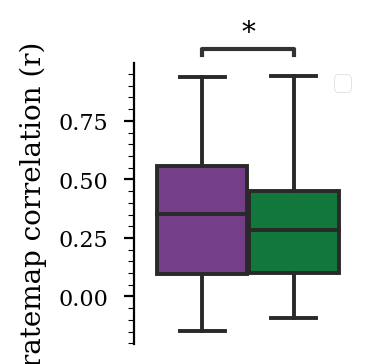

In [22]:
plt.figure(figsize=functions.set_size("thesis", fraction=.25, subplots=(2, 1)))

group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))


results_df["constant"] = 1

sns.boxplot(
    data=results_df.query("pair_pass_spatial_shuff and not deepSuperficial == 'middle'"),
    y="correlation",
    x="constant",
    showfliers=False,
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
)
plt.ylabel("ratemap correlation (r)")
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)
ax.set_xlabel("")
ax.legend("")

box_pairs = [
    ((1, "Deep"), (1, "Superficial")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=results_df.query("pair_pass_spatial_shuff and not deepSuperficial == 'middle'"),
    x="constant",
    y="correlation",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
)
annotator.configure(
    test="Mann-Whitney-gt",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=1,
)
annotator.apply_and_annotate()

plt.savefig(
    os.path.join(fig_save_path, "ratemap_correlations_same_maze_epochs.svg"),
    dpi=300,
    bbox_inches="tight",
)

plt.show()

In [24]:
# results_df.query("pair_pass_spatial_shuff and not deepSuperficial == 'middle'")
results_df = functions.add_animal_id(results_df)
results_df.animal_id.nunique()

8

In [27]:
results_df.groupby("basepath").UID.nunique().sum()

598

## Testing below

In [6]:
basepath = r"Z:\Data\Kenji\ec013.370_390"
# load position
position_df = loading.load_animal_behavior(basepath)
position_df_no_nan = position_df.query("not x.isnull() & not y.isnull()")

st,cm = loading.load_spikes(basepath,putativeCellType="Pyr",brainRegion="CA1")

cm = add_new_deep_sup.deep_sup_from_distance(cm)

pos = nel.PositionArray(
    data=position_df_no_nan[["x", "y"]].values.T,
    timestamps=position_df_no_nan.timestamps.values,
)
beh_df = loading.load_epoch(basepath)
beh_df = beh_df.query("environment != 'sleep'")

beh_epochs = nel.EpochArray(np.array([beh_df.startTime,beh_df.stopTime]).T)

# tc = maps.SpatialMap(pos[epochs[4]],st[epochs[4]],dim=2)
beh_df

,name,startTime,stopTime,environment,behavioralParadigm,basepath
3,ec013.374_linear,2028.3390,3104.7680,linear,10,Z:\Data\Kenji\ec013.370_390
4,ec013.375_linear,3104.7680,4861.9520,linear,10,Z:\Data\Kenji\ec013.370_390
8,ec013.379_wheel,10726.2044,11345.4044,wheel,10,Z:\Data\Kenji\ec013.370_390
9,ec013.380_wheel,11345.4044,11983.1044,wheel,10,Z:\Data\Kenji\ec013.370_390
12,ec013.383_bigSquare,12555.3156,13577.2676,bigSquare,10,Z:\Data\Kenji\ec013.370_390
13,ec013.384_bigSquare,13577.2676,15136.2056,bigSquare,10,Z:\Data\Kenji\ec013.370_390
14,ec013.385_linear,15136.2056,15235.1056,linear,10,Z:\Data\Kenji\ec013.370_390
15,ec013.386_linear,15235.1056,16109.1920,linear,10,Z:\Data\Kenji\ec013.370_390
16,ec013.387_linear,16109.1920,16766.6000,linear,10,Z:\Data\Kenji\ec013.370_390
17,ec013.388_linear,16766.6000,17773.3970,linear,10,Z:\Data\Kenji\ec013.370_390


In [7]:
def find_repeated_strings(lst):
    if not isinstance(lst, list):
        try:
            lst = list(lst)
        except:
            raise TypeError("lst must be a list or a list-like object")
    repeated_strings = {}
    for i in range(len(lst)):
        if lst[i] in repeated_strings:
            repeated_strings[lst[i]].append(i)
        elif lst.count(lst[i]) > 1:
            repeated_strings[lst[i]] = [i]
    return repeated_strings

tasks = find_repeated_strings(list(beh_df.environment.values))

tasks

{'linear': [0, 1, 6, 7, 8, 9], 'wheel': [2, 3], 'bigSquare': [4, 5]}

In [8]:
for task in tasks:
    print(task, tasks[task])

linear [0, 1, 6, 7, 8, 9]
wheel [2, 3]
bigSquare [4, 5]


In [15]:
def ratemap_cor(A, B):
    # for given ratemaps A & B, find their correlation
    # Calling the crossCorr function
    x1 = A.flatten()
    x2 = B.flatten()
    bad_idx = np.isnan(x1) | np.isnan(x2)
    return np.corrcoef(x1[~bad_idx], x2[~bad_idx])[0, 1]

results_df = pd.DataFrame()
for task in tasks:

    results_df_temp = pd.DataFrame()
    # linearize position if necessary
    if "linear" in task:
        for i in tasks[task]:
            idx = functions.in_intervals(pos.abscissa_vals, beh_epochs[i].data)
            x, y = pos.data[:, idx]
            pos._data[:, idx] = functions.linearize_position(x, y)
            
    # pull out coordinates for for this task type to get spatial extent
    current_pos = pos[beh_epochs[tasks[task]]]
    if current_pos.isempty:
        continue
    xminmax = [np.nanmin(current_pos.data[0, :]), np.nanmax(current_pos.data[0, :])]
    yminmax = [np.nanmin(current_pos.data[1, :]), np.nanmax(current_pos.data[1, :])]

    # find ratemaps for each cell
    # for reduced complexity, using 2d spatial maps and not splitting by direction (linear track)
    ratemaps = []
    spatial_pval = []
    for i in tasks[task]:
        if pos[beh_epochs[i]].isempty | st[beh_epochs[i]].isempty:
            continue
        spatial_maps = maps.SpatialMap(
            pos[beh_epochs[i]],
            st[beh_epochs[i]],
            dim=2,
            s_binsize=3,
            x_minmax=xminmax,
            y_minmax=yminmax,
            tuning_curve_sigma=3,
            n_shuff = 5,
            parallel_shuff=False
        )
        # store ratemaps
        ratemaps.append(spatial_maps.ratemap)
        # store p-values for spatial information shuffle
        spatial_pval.append(spatial_maps.shuffle_spatial_information())

    # find correlation between all pairs of ratemaps for each cell
    # find all pairs of ratemaps
    pairs = np.array(list(combinations(np.arange(0, len(ratemaps)), 2)))
    # set up array to store correlations
    within_corr = np.zeros((len(st.data), len(pairs)))
    # loop through pairs
    for pair_i, s in enumerate(pairs):
        # loop through cells
        for cell_i in range(len(st.data)):
            # find correlation between ratemaps
            within_corr[cell_i, pair_i] = ratemap_cor(
                ratemaps[s[0]][cell_i, :, :], ratemaps[s[1]][cell_i, :, :]
            )
    # take mean across pairs
    within_corr = np.nanmean(within_corr, axis=1)
    results_df_temp["corr"] = within_corr
    results_df_temp["n_pass_spatial_shuff"] = np.sum(np.vstack(spatial_pval) < 0.05,axis=0)
    results_df_temp["UID"] = cm.UID.values
    results_df_temp["deepSuperficial"] = cm.deepSuperficial.values
    results_df_temp["task"] = task
    results_df = pd.concat([results_df, results_df_temp], ignore_index=True)

d:\github\ripple_heterogeneity\ripple_heterogeneity\place_cells\maps.py:276: RuntimeWarning: divide by zero encountered in divide
d:\github\ripple_heterogeneity\ripple_heterogeneity\place_cells\maps.py:276: RuntimeWarning: invalid value encountered in divide
d:\github\ripple_heterogeneity\ripple_heterogeneity\place_cells\maps.py:276: RuntimeWarning: divide by zero encountered in divide
d:\github\ripple_heterogeneity\ripple_heterogeneity\place_cells\maps.py:276: RuntimeWarning: invalid value encountered in divide


In [16]:
results_df

,corr,n_pass_spatial_shuff,UID,deepSuperficial,task
0,0.133299,0,54,Deep,linear
1,0.096140,0,56,middle,linear
2,0.070888,0,57,middle,linear
3,0.307997,0,68,Deep,linear
4,0.100387,0,73,middle,linear
5,0.089157,0,78,Deep,linear
6,0.235642,0,80,Deep,linear
7,0.236726,0,83,Deep,linear
8,0.273530,0,84,Deep,linear
9,0.275972,0,88,Deep,linear
